In [1]:
#initialize dependencies, h2o as primary
import datetime  # for timestamp
import h2o  # base h2o package for python
from h2o.estimators.glm import H2OGeneralizedLinearEstimator  # h2o elastic net models class
from h2o.grid.grid_search import H2OGridSearch  # grid search class and syntax for h2o models
from interpret import show  # basic visualizations from interpret package
from interpret.glassbox import ExplainableBoostingClassifier  # interpret ebm class
from interpret.perf import ROC  # ROC measure for ebm
import itertools  # for cartesian product of parameters
import matplotlib.pyplot as plt  # basic plotting
import numpy as np  # for basic array manipulation
import pandas as pd  # for dataframe manipulation
import seaborn as sns  # slightly better plotting
import time  # for timers
import xgboost as xgb  # base xgboost package for python
import random  # to sample from lists
from sklearn.metrics import accuracy_score, f1_score  # for selecting model cutoffs

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='6G',
         nthreads=NTHREAD)  # start h2o with plenty of memory and threads
h2o.remove_all()  # clears h2o memory
h2o.no_progress()  # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 42 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,23 days
H2O_cluster_name:,H2O_from_python_zvila_8p43h7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
#import data (test data will not be used for model fitting)
data = pd.read_csv('hmda_train_preprocessed.csv')
test = pd.read_csv('hmda_test_preprocessed.csv')

# Feature Assignment (Parametric Model)

In [3]:
#assign x and y features
y_name = 'high_priced'
x_names = [
    'term_360', 'conforming', 'debt_to_income_ratio_missing',
    'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
    'intro_rate_period_std', 'property_value_std', 'income_std',
    'debt_to_income_ratio_std'
]

## Boxplots of Features

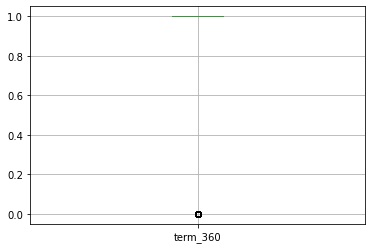

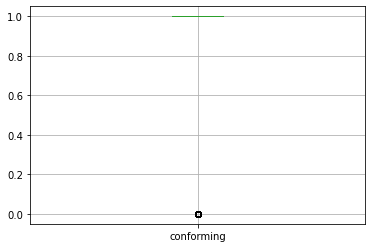

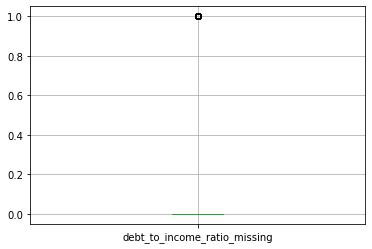

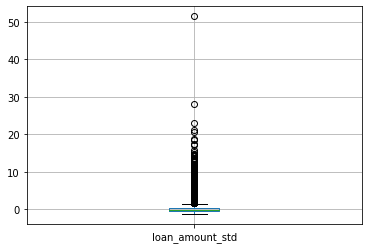

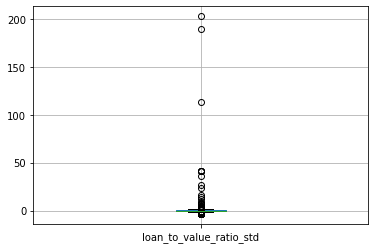

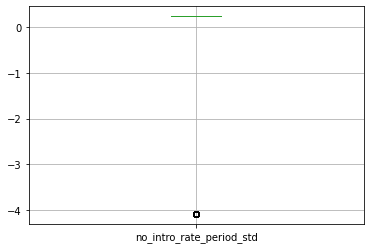

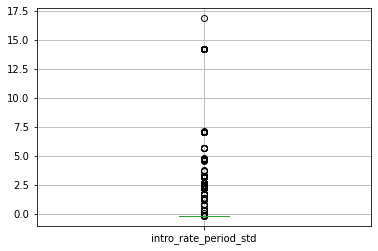

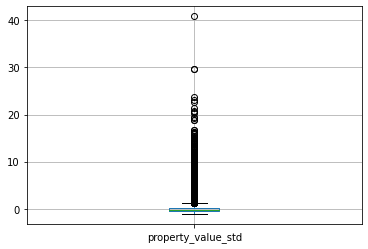

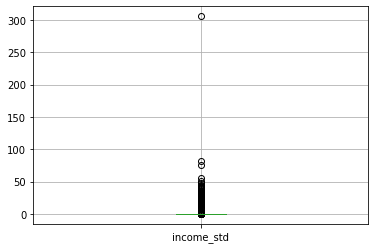

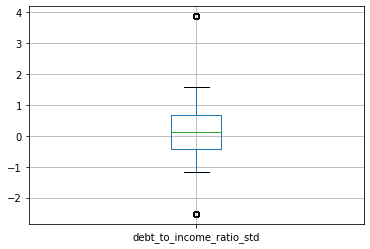

In [4]:
#data exploration with boxplots
for i in data[x_names]:
    data[x_names].boxplot(column=i)
    plt.show()

# Correlation of Features & Predictor (High-Priced)

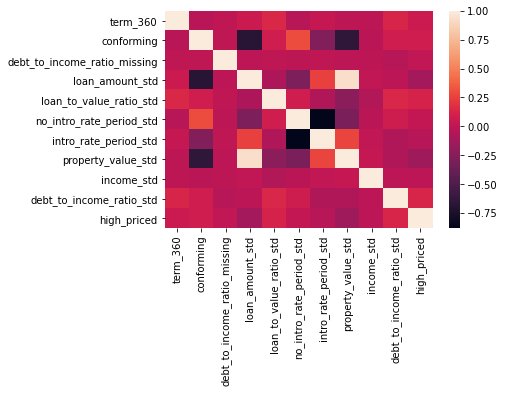

In [5]:
#correlation analysis
corr = data[x_names + [y_name]].corr()
_ = sns.heatmap(corr,
                xticklabels=corr.columns.values,
                yticklabels=corr.columns.values)

# Data Partitioning: Training & Validation Sets

In [6]:
#partition data
np.random.seed(SEED)  # preserve reproducibility

split_ratio = 0.70  # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Training data = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

Training data = 112253, columns = 23
Validation data = 48085, columns = 23


# Explainable Boosting Machine Model

In [7]:
#Define function for random grid search
def ebm_grid(train,
             valid,
             x_names,
             y_name,
             gs_params=None,
             n_models=None,
             early_stopping_rounds=None,
             seed=None):
    """ Performs a random grid search over n_models and gs_params.

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :return: Best candidate model from random grid search.

    """

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {
        'n_jobs': NTHREAD,
        'early_stopping_rounds': early_stopping_rounds,
        'random_state': SEED
    }

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp]
                      )  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)
        candidate = ebm.fit(train[x_names], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[x_names],
                                                       valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_candidate = candidate
            best_score = candidate_best_score
            print(
                'Grid search new best score discovered at iteration %d/%d: %.4f.'
                % (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del ebm

    return best_candidate

## Random Grid Search: EBM Model Fit (10 iterations)

Utilize Early Stopping to minimize overfitting

In [8]:
# dictionary of hyperparameter value lists for grid search
gs_params = {
    'max_bins': [128, 256, 512],
    'max_interaction_bins': [16, 32, 64],
    'interactions': [10, 15, 20],
    'outer_bags': [6, 10, 14],
    'inner_bags': [0, 4, 8],
    'learning_rate': [0.005, 0.001, 0.01, 0.05],
    'validation_size': [0.2, 0.4, 0.5],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_leaves': [3, 5, 7]
}

# EBM grid search, use early stopping
best_ebm = ebm_grid(train,
                    valid,
                    x_names,
                    y_name,
                    gs_params=gs_params,
                    n_models=10,
                    early_stopping_rounds=100,
                    seed=SEED)

Grid search run 1/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 6, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.2, 'min_samples_leaf': 10, 'max_leaves': 5}
Grid search new best score discovered at iteration 1/10: 0.8240.
---------- ----------
Grid search run 2/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 6, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.4, 'min_samples_leaf': 1, 'max_leaves': 5}
---------- ----------
Grid search run 3/10:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 14, 'inner_bags': 0, 'learning_rate': 0.005, 'validation_size': 0.4, 'min_samples_leaf': 2, 'm

### Model Assessment: AUC of Best Model

In [9]:
best_ebm_perf = ROC(best_ebm.predict_proba).explain_perf(
    valid[x_names], valid[y_name])
print('Validation AUC: %.5f.' % best_ebm_perf._internal_obj['overall']['auc'])

Validation AUC: 0.82449.


In [10]:
#create submission file
best_ebm_submit = pd.DataFrame(best_ebm.predict_proba(test[x_names])[:, 1],
                               columns=['phat'])
best_ebm_submit.to_csv(
    'ph_best_ebm_' +
    str(datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.csv'),
    index=False)

### Evaluate Validation data

In [11]:
#validation data scoring
best_ebm_phat = pd.DataFrame(best_ebm.predict_proba(valid[x_names])[:, 1],
                             columns=['phat'])
best_ebm_phat = pd.concat([valid.reset_index(drop=True), best_ebm_phat],
                          axis=1)
best_ebm_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.183249
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.319263
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.021405
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.015700
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004152


In [12]:
#utility function for selecting percentiles
def get_percentile_dict(yhat_name, frame, id_):
    """ Returns the percentiles of a column, yhat_name, as the indices based on
        another column id_.
        :param yhat_name: Name of column in frame in which to find percentiles.
        :param frame: Pandas frame.
        :param id_: Validation Pandas frame containing yhat and id_.
        :return: Dictionary of percentile values and index column values.
    """

    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat_name, inplace=True)
    sort_df.reset_index(inplace=True)

    # find top and bottom percentiles
    percentiles_dict = {
        0: sort_df.loc[0, id_],
        99: sort_df.loc[sort_df.shape[0] - 1, id_]
    }

    # find 10th-90th percentiles
    inc = sort_df.shape[0] // 10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc, id_]

    return percentiles_dict

In [13]:
#select percentiles from predictions
best_ebm_percentiles = get_percentile_dict('phat', best_ebm_phat, 'row_id')
for key in sorted(best_ebm_percentiles.keys()):
    print(str(key) + ': ' + str(best_ebm_percentiles[key]))

0: 64814
10: 67198
20: 67762
30: 132577
40: 9232
50: 14332
60: 66917
70: 9635
80: 24145
90: 128543
99: 48124


### EBM Contributions

In [16]:
#calculate EBM contributions

# use EBM feature scores as local importance
# use mean abs score as global importance
best_ebm_contribs = best_ebm.explain_local(valid[x_names])
names = best_ebm_contribs._internal_obj['specific'][0]['names']
best_ebm_contribs_df = pd.DataFrame(columns=names)

# extract scores from insane _internal_obj
# new versions just have predict_and_explain() function
# use that if you can
for i in range(0, valid.shape[0]):
    row_df = pd.DataFrame(np.array(
        best_ebm_contribs._internal_obj['specific'][i]['scores']).reshape(
            1, 25),
                          columns=names)
    best_ebm_contribs_df = best_ebm_contribs_df.append(row_df,
                                                       ignore_index=True)
    del row_df

In [17]:
# use coefficients as relative global feature importance
global_fi = pd.DataFrame()

#assign variable
global_fi['EBM Importance'] = np.abs(best_ebm_contribs_df).mean()

### Compile local feature importance

In [18]:
valid_idx_map = valid['row_id'].copy(deep=True)
valid_idx_map.reset_index(drop=True, inplace=True)

# init frame to store local contribs
local_fi_dict = {
    10: pd.DataFrame(columns=['EBM Contribution'], index=x_names),
    50: pd.DataFrame(columns=['EBM Contribution'], index=x_names),
    90: pd.DataFrame(columns=['EBM Contribution'], index=x_names)
}

# extract scores at three percentiles of phat
for percentile in [10, 50, 90]:

    # using valid_idx_map and percentiles dict
    # to find the right local contributions
    idx = valid_idx_map[valid_idx_map == int(
        best_ebm_percentiles[percentile])].index[0]
    s_df = best_ebm_contribs_df.iloc[idx, :len(x_names)].T
    s_df.columns = ['EBM Contribution']
    local_fi_dict[percentile]['EBM Contribution'] = s_df

## Feature Analysis

### Global Importance

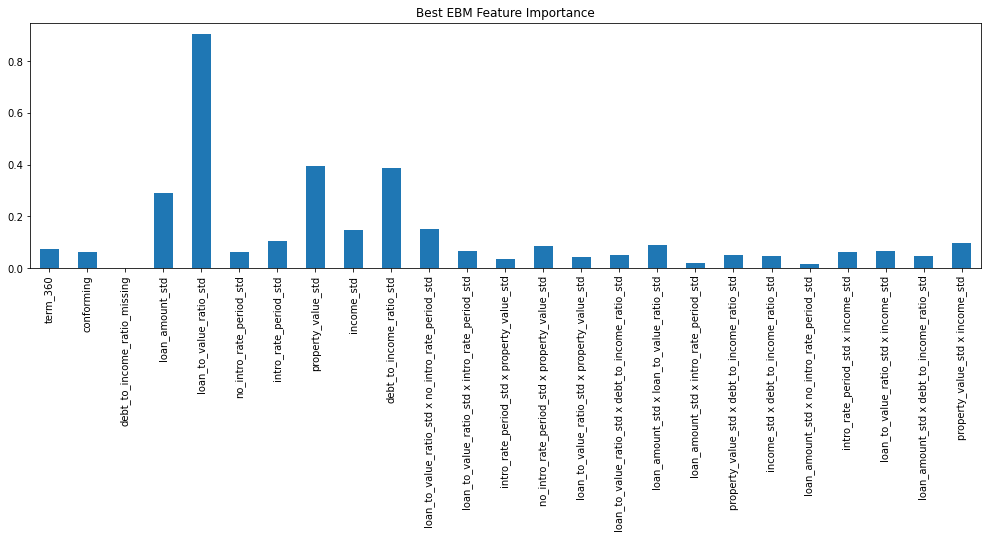

In [19]:
# init plot
fig, (ax2) = plt.subplots(ncols=1)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

# plot global FI
_ = global_fi['EBM Importance'].plot(kind='bar',
                                     ax=ax2,
                                     title='Best EBM Feature Importance')

### Localized Importance

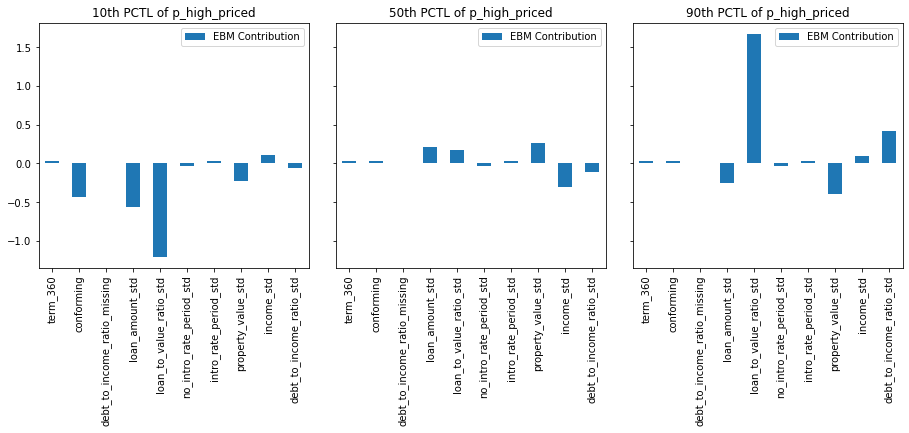

In [20]:
## init 3-pane plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=True)
plt.tight_layout()
plt.subplots_adjust(left=0, right=2, wspace=0.1)

# plot comparisons of local FI across 3 panes
_ = local_fi_dict[10].plot(kind='bar',
                           ax=ax0,
                           title='10th PCTL of p_high_priced')

_ = local_fi_dict[50].plot(kind='bar',
                           ax=ax1,
                           title='50th PCTL of p_high_priced')

_ = local_fi_dict[90].plot(kind='bar',
                           ax=ax2,
                           title='90th PCTL of p_high_priced')

### Partial Dependence: Utility Function

In [21]:
def par_dep(x_name, valid, model, model_type, resolution=20, bins=None):
    """ Creates Pandas DataFrame containing partial dependence or ICE
        for a single input variable.
        :param x_name: Variable for which to calculate partial dependence.
        :param valid: Pandas validation frame.
        :param model: Trained model object (assumes binary classifier).
        :param model_type: Kind of model: h2o, xgb, or ebm.
        :param resolution: The number of points across the domain of xs for which
                           to calculate partial dependence, default 20.
        :param bins: List of values at which to set xs, default 20 equally-spaced
                     points between column minimum and maximum.
        :return: Pandas DataFrame containing partial dependence values.
    """

    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None

    # determine values at which to calculate partial dependence
    if bins is None:
        min_ = valid[x_name].min()
        max_ = valid[x_name].max()
        by = (max_ - min_) / resolution
        # modify max and by
        # to preserve resolution and actually search up to max
        bins = np.arange(min_, (max_ + by), (by + np.round(
            (1. / resolution) * by, 3)))

    # cache original column values
    col_cache = valid.loc[:, x_name].copy(deep=True)

    # calculate partial dependence
    # by setting column of interest to constant
    # and scoring the altered data and taking the mean of the predictions
    temp_df = valid.copy(deep=True)
    temp_df.loc[:, x_name] = bins[0]
    for j, _ in enumerate(bins):
        if j + 1 < len(bins):
            valid.loc[:, x_name] = bins[j + 1]
            temp_df = temp_df.append(valid, ignore_index=True)

    # return input frame to original cached state
    valid.loc[:, x_name] = col_cache

    # model predictions
    # probably assumes binary classification
    if model_type == 'h2o':
        temp_df['partial_dependence'] = model.predict(
            h2o.H2OFrame(temp_df))['p1'].as_data_frame()
    if model_type == 'xgb':
        temp_df['partial_dependence'] = pd.DataFrame(model.predict(
            xgb.DMatrix(temp_df),
            iteration_range=(0, best_mxgb.best_ntree_limit)),
                                                     columns=['phat'])
    if model_type == 'ebm':
        temp_df['partial_dependence'] = pd.DataFrame(
            model.predict_proba(temp_df)[:, 1], columns=['phat'])

    return pd.DataFrame(temp_df[[x_name, 'partial_dependence'
                                 ]].groupby([x_name]).mean()).reset_index()

In [22]:
#calculate partial dependence
# init dict to hold results
pd_dict = {}

# cycle through names and model types to calculate par dep
for name in x_names:

    print('Calculating partial dependence for %s ...' % name)

    # setup a dataframe to hold results
    # use bins from first par_dep() run
    pd_dict[name] = pd.DataFrame(columns=[name, 'ebm'])
    first_pd = par_dep(name, valid[x_names], best_ebm, 'ebm')
    pd_dict[name][name] = first_pd[name]
    bins = first_pd[name]

    # calculate par dep for ebm model
    pd_dict[name]['ebm'] = par_dep(name,
                                   valid[x_names],
                                   best_ebm,
                                   'ebm',
                                   bins=bins)['partial_dependence']

print('Done.')

Calculating partial dependence for term_360 ...
Calculating partial dependence for conforming ...
Calculating partial dependence for debt_to_income_ratio_missing ...
Calculating partial dependence for loan_amount_std ...
Calculating partial dependence for loan_to_value_ratio_std ...
Calculating partial dependence for no_intro_rate_period_std ...
Calculating partial dependence for intro_rate_period_std ...
Calculating partial dependence for property_value_std ...
Calculating partial dependence for income_std ...
Calculating partial dependence for debt_to_income_ratio_std ...
Done.


## Partial Dependence Plots

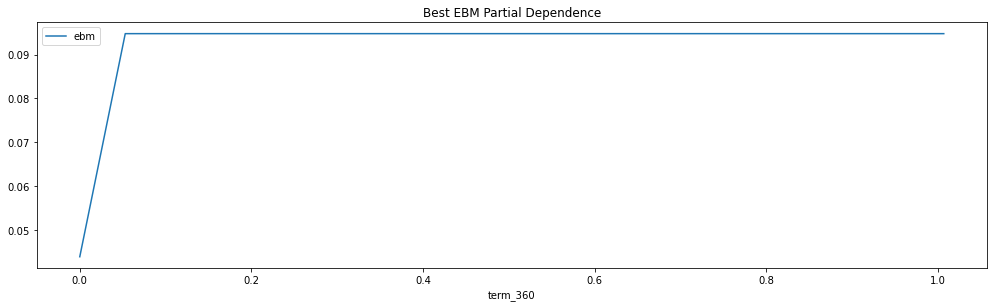

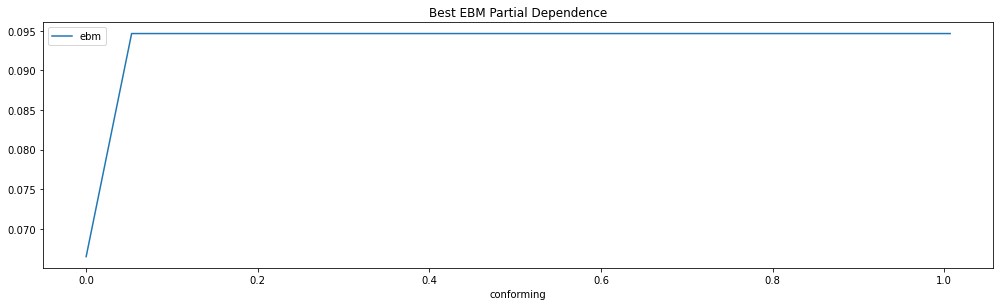

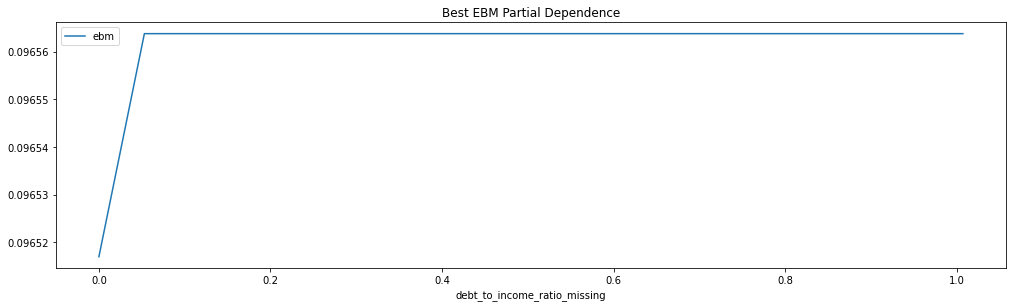

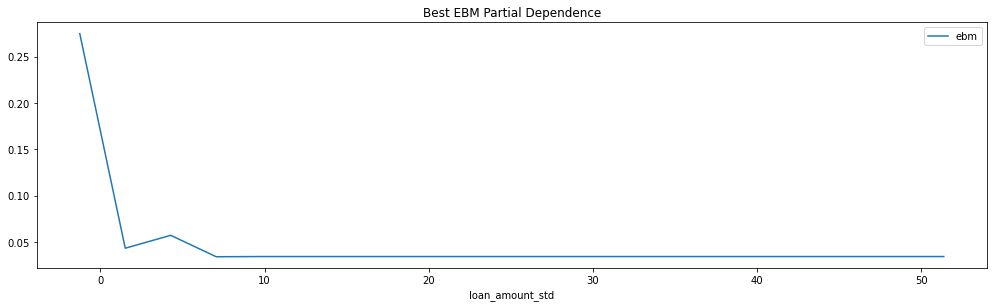

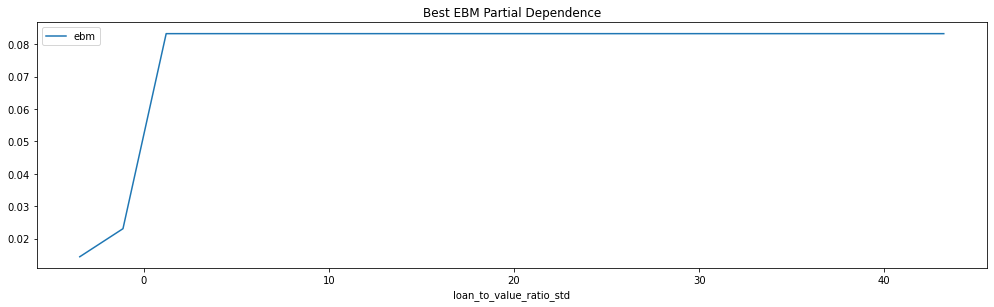

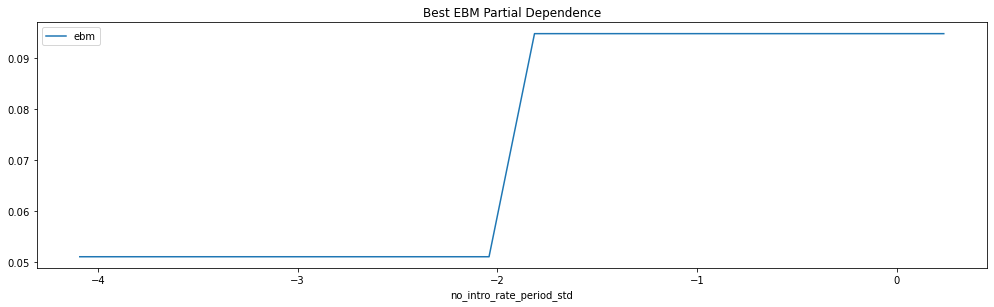

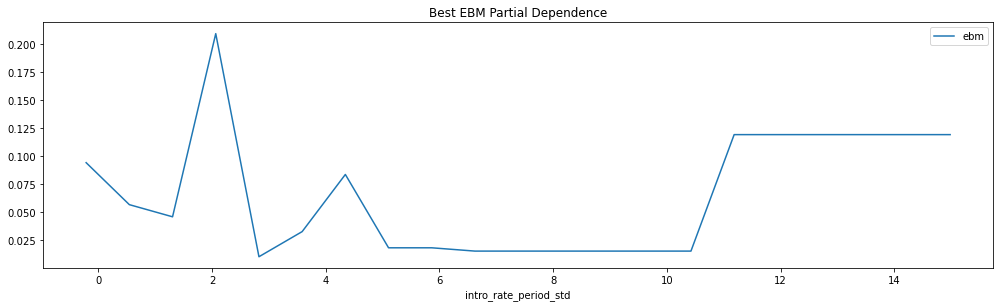

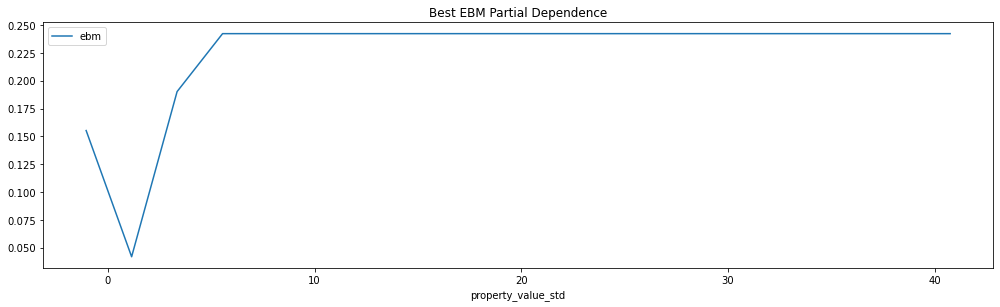

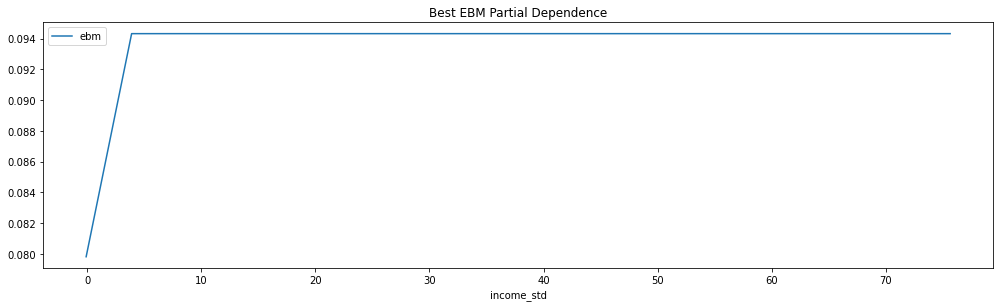

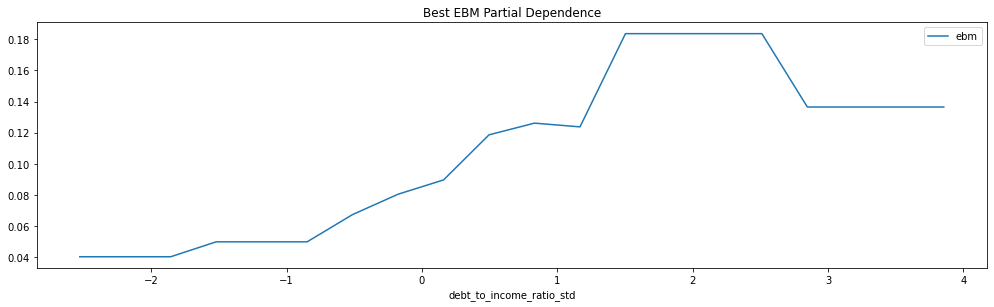

In [23]:
# loop through names to calculate par dep
for name in x_names:

    # init plot
    fig, (ax2) = plt.subplots(ncols=1, sharey=True)
    plt.tight_layout()
    plt.subplots_adjust(left=0, right=2.2, wspace=0.2)

    # plot par dep from model across frames
    pd_dict[name].plot(kind='line',
                       x=name,
                       y='ebm',
                       ax=ax2,
                       title='Best EBM Partial Dependence')
    ax2.set_xlabel(name)

# Remediation: Model Discrimination Testing

## Utility Functions

In [24]:
#calculate confusion matrices by demographic group
def get_confusion_matrix(frame,
                         y,
                         yhat,
                         by=None,
                         level=None,
                         cutoff=0.5,
                         verbose=True):
    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' + str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff, 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i)
                                        & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19

    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

In [25]:
#calculate AIR
def air(cm_dict, reference_key, protected_key, verbose=True):
    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20  # numeric stability and divide by 0 protection

    # reference group summary
    reference_accepted = float(
        cm_dict[reference_key].iat[1, 0] +
        cm_dict[reference_key].iat[1, 1])  # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted / reference_total
    if verbose:
        print(reference_key.title() +
              ' proportion accepted: %.3f' % reference_prop)

    # protected group summary
    protected_accepted = float(
        cm_dict[protected_key].iat[1, 0] +
        cm_dict[protected_key].iat[1, 1])  # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted / protected_total
    if verbose:
        print(protected_key.title() +
              ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps) / (reference_prop + eps))

In [26]:
#f1 score
def get_max_f1_frame(frame,
                     y,
                     yhat,
                     res=0.01,
                     air_reference=None,
                     air_protected=None):
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """

    do_air = all(v is not None for v in [air_reference, air_protected])

    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])

    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)

    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR
            cm_ref = get_confusion_matrix(frame,
                                          y,
                                          yhat,
                                          by=air_reference,
                                          level=1,
                                          cutoff=cut,
                                          verbose=False)
            cm_pro = get_confusion_matrix(frame,
                                          y,
                                          yhat,
                                          by=air_protected,
                                          level=1,
                                          cutoff=cut,
                                          verbose=False)
            air_ = air({
                air_reference: cm_ref,
                air_protected: cm_pro
            },
                       air_reference,
                       air_protected,
                       verbose=False)
            row_dict['air'] = air_

        f1_frame = f1_frame.append(row_dict, ignore_index=True)

    del temp_df

    return f1_frame

In [27]:
#ebm grid search for maximum fidelity and least discrimination
def ebm_grid(train,
             valid,
             x_names,
             y_name,
             gs_params=None,
             n_models=None,
             early_stopping_rounds=None,
             seed=None,
             air_reference=None,
             air_protected=None,
             air_cut=None):
    """ Performs a random grid search over n_models and gs_params.
        Optionally considers random feature sets and AIR.
        Coupled to get_confusion_matrix() and air(). 

    :param train: Training data as Pandas DataFrame.
    :param valid: Validation data as Pandas DataFrame.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param gs_params: Dictionary of lists of potential EBM parameters over which to search.   
    :param n_models: Number of random models to evaluate.
    :param early_stopping_rounds: EBM early stopping rounds.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.  
    :param air_cut: Cutoff for AIR calculation, optional.
    :return: Tuple: (Best EBM model, Pandas DataFrame of models to select from)

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air:
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    ebm_grid_frame = pd.DataFrame(columns=columns)

    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED)

    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for seed, etc.
    params = {
        'n_jobs': NTHREAD,
        'early_stopping_rounds': early_stopping_rounds,
        'random_state': SEED
    }

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):

        params.update(experiments[exp]
                      )  # override global params with current grid run params

        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # train
        ebm = ExplainableBoostingClassifier(**params)

        # conditionally select random features
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
        candidate = ebm.fit(train[features], train[y_name])

        # calculate AUC
        ebm_perf = ROC(ebm.predict_proba).explain_perf(valid[features],
                                                       valid[y_name])
        candidate_best_score = ebm_perf._internal_obj['overall']['auc']

        # compose values to add to ebm_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate_best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict_proba(valid[features])[:, 1]
            cm_ref = get_confusion_matrix(valid_phat,
                                          y_name,
                                          'phat',
                                          by=air_reference,
                                          level=1,
                                          cutoff=air_cut,
                                          verbose=False)
            cm_pro = get_confusion_matrix(valid_phat,
                                          y_name,
                                          'phat',
                                          by=air_protected,
                                          level=1,
                                          cutoff=air_cut,
                                          verbose=False)
            air_ = air({
                air_reference: cm_ref,
                air_protected: cm_pro
            },
                       air_reference,
                       air_protected,
                       verbose=False)
            row_dict['air'] = air_
            del valid_phat

        # append run to ebm_grid_frame
        ebm_grid_frame = ebm_grid_frame.append(row_dict, ignore_index=True)

        # determine if current model is better than previous best
        if candidate_best_score > best_score:
            best_score = candidate_best_score
            best_ebm = candidate
            print(
                'Grid search new best score discovered at iteration %d/%d: %.4f.'
                % (int(i + 1), int(n_models), candidate_best_score))

        print('---------- ----------')

        del row_dict
        del ebm

    return best_ebm, ebm_grid_frame

## Discrimination Analysis

In [28]:
#Find optimal cutoff based on F1
f1_frame = get_max_f1_frame(best_ebm_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[
    int(f1_frame['f1'].idxmax()),
    'cut']  #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.3f with accuracy: %.5f.' %
      (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.232456  0.379245
2    0.02  0.262047  0.477717
3    0.03  0.279386  0.527753
4    0.04  0.294159  0.565956
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3661 achieved at cutoff: 0.170 with accuracy: 0.78168.


In [29]:
#Find confusion matrices for demographic groups
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_ebm_phat,
                                         y_name,
                                         'phat',
                                         by=name,
                                         level=1,
                                         cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       490       981
predicted: 0       174      1547

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        97       208
predicted: 0        51      2894

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      2070      6605
predicted: 0      1095     24755

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1106      3408
predicted: 0       558     10760

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       888      2361
predicted: 0       352      6431



In [30]:
#AIR for Asian race
print('Adverse impact ratio for Asian people vs. White people: %.3f' %
      air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.749
Asian proportion accepted: 0.906
Adverse impact ratio for Asian people vs. White people: 1.210


In [31]:
#AIR for Black race
print('Adverse impact ratio for Black people vs. White people: %.3f' %
      air(cm_dict, 'white', 'black'))

White proportion accepted: 0.749
Black proportion accepted: 0.539
Adverse impact ratio for Black people vs. White people: 0.720


In [32]:
#AIR for Female Gender
print('Adverse impact ratio for Females vs. Males: %.3f' %
      air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.715
Female proportion accepted: 0.676
Adverse impact ratio for Females vs. Males: 0.946


## Remediation Techniques & Disparate Impact Analysis

### Evaluate new AUC cutoff maximizing AIR

In [33]:
#Find cutoff with better Black vs. White AIR
f1_frame = get_max_f1_frame(best_ebm_phat,
                            y_name,
                            'phat',
                            air_reference='white',
                            air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
21,0.21,0.360741,0.826349,0.801475
22,0.22,0.350874,0.834793,0.826468
23,0.23,0.344449,0.843423,0.850169
24,0.24,0.337286,0.852407,0.870398
25,0.25,0.325863,0.861121,0.881443


In [40]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_ebm_phat,
                                             y_name,
                                             'phat',
                                             by=name,
                                             level=1,
                                             cutoff=0.21,
                                             verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' %
      air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' %
      air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' %
      air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.137
Adverse impact ratio for Black people vs. White people: 0.801
Adverse impact ratio for Females vs. Males: 0.967


### Perform new EBM grid search with adjusted parameters (100 Iterations)

In [35]:
# new grid search that also considers AIR and fairness
best_ebm2, ebm_grid_frame = ebm_grid(train,
                                     best_ebm_phat,
                                     x_names,
                                     y_name,
                                     gs_params=gs_params,
                                     n_models=100,
                                     early_stopping_rounds=100,
                                     seed=SEED,
                                     air_reference='white',
                                     air_protected='black',
                                     air_cut=0.17)

Grid search run 1/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 64, 'interactions': 15, 'outer_bags': 6, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.2, 'min_samples_leaf': 10, 'max_leaves': 5}
Grid search new best score discovered at iteration 1/100: 0.7323.
---------- ----------
Grid search run 2/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 256, 'max_interaction_bins': 16, 'interactions': 10, 'outer_bags': 6, 'inner_bags': 0, 'learning_rate': 0.01, 'validation_size': 0.4, 'min_samples_leaf': 1, 'max_leaves': 5}
Grid search new best score discovered at iteration 2/100: 0.7832.
---------- ----------
Grid search run 3/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 15, 'outer_bags': 14, 'inner_bags': 0, 'le

Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 20, 'outer_bags': 6, 'inner_bags': 0, 'learning_rate': 0.005, 'validation_size': 0.5, 'min_samples_leaf': 5, 'max_leaves': 7}
---------- ----------
Grid search run 26/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 128, 'max_interaction_bins': 16, 'interactions': 20, 'outer_bags': 6, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.2, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 27/100:
Training with parameters: {'n_jobs': 4, 'early_stopping_rounds': 100, 'random_state': 12345, 'max_bins': 512, 'max_interaction_bins': 64, 'interactions': 20, 'outer_bags': 6, 'inner_bags': 4, 'learning_rate': 0.01, 'validation_size': 0.2, 'min_samples_leaf': 2, 'max_leaves': 5}
---------- ----------
Grid search run 28/100:
Training with parameters

limit_output extension: Maximum message size of 10000 exceeded with 10021 characters

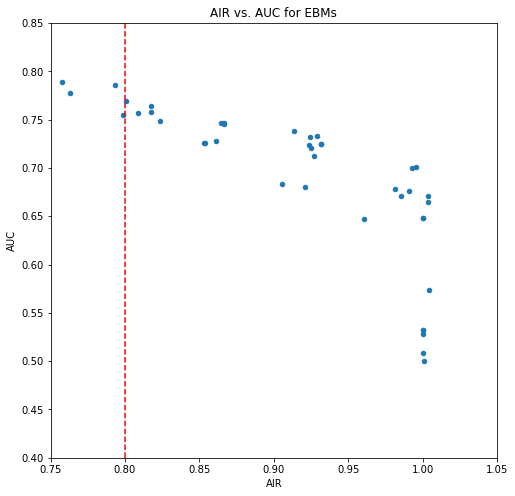

In [36]:
#display grid search results (table)
ebm_grid_frame

#display grid search results (plot)
fig, ax = plt.subplots(figsize=(8, 8))
_ = ebm_grid_frame.plot(kind='scatter',
                        x='air',
                        y='auc',
                        title='AIR vs. AUC for EBMs',
                        ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

## Retrain Model & Evaluate Results

In [37]:
#Retrain most accurate model above 0.8 AIR
# extract new params dict from ebm_grid_frame
rem_params = ebm_grid_frame.loc[ebm_grid_frame['air'] > 0.8].sort_values(
    by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict
rem_x_names = rem_params['features']
del rem_params['features']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' %
      (rem_params['auc'], rem_params['air']))
del rem_params['auc']
del rem_params['air']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names],
                                                       valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Best AUC: 0.7694 above 0.8 AIR (0.8010).
Remediated EBM retrained with AUC: 0.7694.


In [38]:
#Check that other groups are not adversely impacted by change
# create a frame with remediated EBM predictions
best_ebm_phat2 = pd.DataFrame(rem_ebm.predict_proba(valid[rem_x_names])[:, 1],
                              columns=['phat'])
best_ebm_phat2 = pd.concat([valid.reset_index(drop=True), best_ebm_phat2],
                           axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_ebm_phat2,
                                              y_name,
                                              'phat',
                                              by=name,
                                              level=1,
                                              cutoff=0.17,
                                              verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' %
      air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' %
      air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' %
      air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.175
Adverse impact ratio for Black people vs. White people: 0.801
Adverse impact ratio for Females vs. Males: 0.954


In [39]:
#end h2o
h2o.cluster().shutdown(prompt=False)

H2O session _sid_87b9 closed.
